# LIBRARY
This code snippet sets up the necessary environment for deep learning with PyTorch, including GPU device selection, random seed initialization, and importing relevant libraries for working with pre-trained models in NLP tasks. Also important labraries for the usage of Arc Eager Parser and Oracle.


In [43]:
import torch
import torch.nn as nn
from torch import sort as tsort, Tensor
import time
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModel
from transformers.tokenization_utils_base import BatchEncoding
from datasets import load_dataset
from typing import List
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(99)

cpu


# Arc Eager Parser

The code provides an implementation of the Arc Eager parsing algorithm. The Arc Eager algorithm is used to parse sentences and build dependency tree structures.

## Constants
The code defines several constants used in the Arc Eager algorithm:
- `NOMOVE`: Represents no move.
- `LEFT_ARC`: Represents the left-arc move.
- `RIGHT_ARC`: Represents the right-arc move.
- `REDUCE`: Represents the reduce move.
- `SHIFT`: Represents the shift move.
- `IS_FINAL`: Represents the value indicating that the parsing process is finished.
- `EMPTY`: Represents an empty value.

## Class: ArcEager
The `ArcEager` class represents an instance of the Arc Eager parser.

### Initialization
The `ArcEager` class takes a sentence as input and initializes the parsing process. The first element of the sentence must be `ROOT` for a list of words or 1 for a list of integers. The class maintains important data structures: `sentence`, `buffer`, `stack`, `list_arcs`, `list_moves`, and `list_configurations` to keep track of the parsing state and actions.

### Methods
1. `update_configurations`: Updates the `list_configurations` and `list_moves` based on the current move.
2. `left_arc`: Performs the left-arc move by popping the top element from the stack and assigning it as the head of the first element in the buffer.
3. `right_arc`: Performs the right-arc move by assigning the first element in the buffer as the head of the top element in the stack and shifting the first element from the buffer to the stack.
4. `shift`: Performs the shift move by shifting the first element from the buffer to the stack.
5. `reduce`: Performs the reduce move by popping the top element from the stack.
6. `nomove`: Performs the no-move operation, indicating that the parsing process is finished.
7. `do_move`: Performs the specified move by calling the corresponding method based on the move value.
8. `is_tree_final`: Checks if the tree is in its final state, indicating that the parsing process is finished.
9. `print_configuration`: Prints the current configuration of the parser, including the stack, buffer, and list of arcs.
10. `get_list_moves`: Returns the list of moves performed during the parsing process.
11. `get_list_configurations`: Returns the list of configurations encountered during the parsing process.
12. `get_list_arcs`: Returns the list of arcs in the dependency tree.
13. `get_configuration_now`: Returns the current configuration of the parser.

The `ArcEager` class provides functionality to perform the Arc Eager parsing algorithm, including shifting, reducing, and creating arcs based on the input sentence.

## Usage
To use the Arc Eager parser, create an instance of the `ArcEager` class, passing the sentence as input. Then, you can perform parsing moves by calling the appropriate methods (`left_arc`, `right_arc`, `shift`, `reduce`, or `nomove`). The current state of the parser can be obtained using the provided getter methods (`get_list_moves`, `get_list_configurations`, `get_list_arcs`, `get_configuration_now`), and the parser's configuration can be printed using the `print_configuration` method.

In [2]:
NOMOVE = -1
LEFT_ARC = 0
RIGHT_ARC = 1
REDUCE = 2
SHIFT = 3

IS_FINAL = -10
EMPTY = -1

class ArcEager:
    def __init__(self, sentence):
        """
        input:
            sentence: list of words | first word must be <ROOT>
            debug: if True print each move
        """
        if all([isinstance(x,str) for x in sentence]):
            if sentence[0] != "<ROOT>":
                raise Exception("ERROR: first word must be <ROOT>")
        elif all([isinstance(x,int) for x in sentence]):
            if sentence[0] != 1: # token of ROOT is 1
                raise Exception("ERROR: first word must be -1")
        else:
            raise Exception("ERROR: sentence must be list of words or list of ints")
            
        self.sentence = sentence
        self.buffer = [i for i in range(len(self.sentence))]
        self.stack = []

        self.list_arcs = [-1 for _ in range(len(self.sentence))]
        self.list_moves=[]
        self.list_configurations = []

        # Do first shift -> add ROOT to stack
        self.stack.append(self.buffer.pop(0))
        self.is_finished=False

    def update_configurations(self, move):
        ''' to do before each move '''
        if move == NOMOVE:
            self.list_configurations.append([EMPTY, EMPTY])
            self.list_moves.append(NOMOVE)
        if len(self.stack)>0:
            self.list_configurations.append([
                self.stack[-1],
                self.buffer[0] if len(self.buffer)>0 else EMPTY
            ])
            self.list_moves.append(move)
            
        
    def left_arc(self):
        self.update_configurations(LEFT_ARC)
        s1 = self.stack.pop(-1)
        b1 = self.buffer[0]
        self.list_arcs[s1] = b1

    def right_arc(self):
        if not is_right_possible(self): 
            self.nomove()
            return
        self.update_configurations(RIGHT_ARC)
        s1 = self.stack[-1]
        b1 = self.buffer.pop(0)
        self.stack.append(b1)
        self.list_arcs[b1] = s1

    def shift(self):
        self.update_configurations(SHIFT)
        self.stack.append(self.buffer.pop(0))

    def reduce(self):
        self.update_configurations(REDUCE)
        self.stack.pop()

    def nomove(self):
        self.is_finished=True
        self.update_configurations(NOMOVE)

    def do_move(self, move:int):
        if move==LEFT_ARC: 
            self.left_arc()
        elif move==RIGHT_ARC:
            self.right_arc()
        elif move==SHIFT:
            self.shift()
        elif move==REDUCE:
            self.reduce()
        elif move==NOMOVE:
            self.nomove()
        return move

    def is_tree_final(self):
        return self.is_finished or (len(self.stack) == 1 and len(self.buffer) == 0) 

    def print_configuration(self):
        s = [self.sentence[i] for i in self.stack]
        b = [self.sentence[i] for i in self.buffer]
        print(s, b)
        print(self.stack, self.buffer)
        print(self.list_arcs)

    def get_list_moves(self):
        return self.list_moves

    def get_list_configurations(self):
        return self.list_configurations

    def get_list_arcs(self):
        return self.list_arcs
    
    def get_configuration_now(self):
        if self.is_tree_final():
            conf=[-1,-1]
        else:
            conf=[self.stack[-1]]
            if len(self.buffer) == 0:
                conf.append(-1)
            else:
                conf.append(self.buffer[0])
        return conf

# Oracle for Arc Eager Parser

The code provides an implementation of an oracle for the Arc Eager parsing algorithm. The oracle is used to guide the parsing process by determining the next move based on the gold standard tree and the current state of the parser.

## Class: Oracle
The `Oracle` class represents the oracle for the Arc Eager parser.

### Initialization
The `Oracle` class takes a parser instance and a gold tree as input and initializes the oracle. It checks the correctness of the gold tree input and stores the parser and gold tree information.

### Methods
1. `is_left_arc_gold`: Checks if there is a link from the top of the buffer to the top of the stack in the gold tree. If a link is present, it returns `True`; otherwise, it returns `False`.
2. `is_right_arc_gold`: Checks if there is a link from the top of the stack to the top of the buffer in the gold tree. If a link is present, it returns `True`; otherwise, it returns `False`.
3. `is_reduce_gold`: Checks if there is a link from a lower position (k) to the top of the buffer or the top of the stack (j), where k is less than the top of the stack (i), in the gold tree. If such a link exists, it returns `False`; otherwise, it returns `True`.
4. `is_shift_gold`: Checks if there is no link from the top of the buffer to the top of the stack, no link from the top of the stack to the top of the buffer, and no link from a lower position to the top of the buffer or the top of the stack in the gold tree. If all conditions are met, it returns `True`; otherwise, it returns `False`.
5. `get_next_move`: Determines the next move based on the current state of the parser and the gold tree. If the parsing process is finished, it returns the constant value `IS_FINAL`. If a left-arc move is possible, it returns the constant value `LEFT_ARC`. If a right-arc move is possible, it returns the constant value `RIGHT_ARC`. If a reduce move is possible, it returns the constant value `REDUCE`. If a shift move is possible, it returns the constant value `SHIFT`. If none of the conditions are met, it prints debug information, including the gold tree and the parser's list of arcs, and exits the program.

The `Oracle` class helps determine the next move in the Arc Eager parsing algorithm based on the gold tree and the current state of the parser.

## Usage
To use the oracle, create an instance of the `Oracle` class, passing the parser and the gold tree as arguments. Then, call the `get_next_move` method to obtain the next move for the parser.

The oracle guides the parsing process by selecting the appropriate move based on the gold standard tree, ensuring that the parser follows the correct syntactic structure.

In [3]:
class Oracle:
    def __init__(self, parser, gold_tree:List[int]):
        self.parser = parser
        self.gold = list(map(int,gold_tree))

        # Check correctness of input
        if self.gold[0] != -1:
            print("ERROR: gold tree must start with -1")
            exit(-1)

    """
    i: top of stack, j: top of buffer
    if there's a link j -> i then return LEFT-ARC
    else if there's a link i -> j then return RIGHT-ARC
    else if there's a link k <-/-> j, k < i then return REDUCE
    else return SHIFT 
    """
    def is_left_arc_gold(self):
        # first element of the of the buffer is the gold head of the topmost element of the stack
        # if empty lists or if top has no head -> return False
        if (
            len(self.parser.buffer) == 0
            or self.parser.stack[-1] == 0  # if top is ROOT
        ):
            return False

        s = self.parser.stack[-1]
        b = self.parser.buffer[0]  # [0]
        if self.gold[s] != b:
            return False

        return True

    def is_right_arc_gold(self):
        # if topmost stack element is gold head of the first element of the buffer
        if len(self.parser.buffer) == 0:
            return False

        s = self.parser.stack[-1]
        b = self.parser.buffer[0]  # [0]
        if self.gold[b] != s:
            return False 

        return True 

    def is_reduce_gold(self):
        s = self.parser.stack[-1]
        if self.parser.list_arcs[s] == -1 or s==0: # if top has no head or if top is ROOT
            return False
        if len(self.parser.buffer) == 0:                    # if buffer is empty
            if self.parser.list_arcs[s] != -1 and s != 0:   # if top has a head and top is not ROOT
                return True
            return False

        for i in range(0, len(self.parser.buffer)):
            b = self.parser.buffer[i]
            if self.gold[b] == s or self.gold[s] == b: # if there's a link k <-/-> j, k < i then do not reduce
                return False 
            
        return True 

    def is_shift_gold(self):
        if len(self.parser.buffer) == 0:
            return False
        if self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold():
            return False
        return True
    
    def get_next_move(self, do_it=False):
        if self.parser.is_tree_final():
            return IS_FINAL
        if self.is_left_arc_gold():
            return LEFT_ARC
        elif self.is_right_arc_gold():
            return RIGHT_ARC
        elif self.is_reduce_gold():
            return REDUCE
        elif self.is_shift_gold():
            return SHIFT
        else:
            print("NO MOVE")
            print(self.gold)
            print(self.parser.list_arcs)
            self.parser.print_configuration()
            exit(-5)
            return None

# Helper Functions
- `is_left_possible(parser)`: This function checks if a left-arc move is possible in the current parser state. It returns `True` if the stack and buffer have at least one element each, and the top element of the stack is not the ROOT element (0). Otherwise, it returns `False`.

- `is_right_possible(parser)`: This function checks if a right-arc move is possible in the current parser state. It returns `True` if the stack and buffer have at least one element each. Otherwise, it returns `False`.

- `is_shift_possible(parser)`: This function checks if a shift move is possible in the current parser state. It returns `True` if the buffer has at least one element. Otherwise, it returns `False`.

- `is_reduce_possible(parser)`: This function checks if a reduce move is possible in the current parser state. It returns `True` if the stack has at least one element and the top element of the stack has a head in the list of arcs. Otherwise, it returns `False`.

These helper functions provide the necessary conditions for determining whether a specific move is valid given the current state of the parser.

You can use these helper functions within the `ArcEager` class methods, such as `left_arc`, `right_arc`, `shift`, and `reduce`, to determine if the corresponding move is possible before performing it.

In [4]:
def is_left_possible(parser):
    return len(parser.stack) >= 1 and len(parser.buffer) >= 1 and parser.stack[-1] != 0

def is_right_possible(parser):
    return len(parser.stack) >= 1 and len(parser.buffer) >= 1

def is_shift_possible(parser):
    return len(parser.buffer) >= 1

def is_reduce_possible(parser):
    return len(parser.stack) >= 1 and parser.list_arcs[parser.stack[-1]] != -1

# Generate Gold and Parser Moves
1. `parse_moves(parsers: List[ArcEager], moves: Tensor)`: This function takes a list of `ArcEager` parsers and a tensor of moves as input. It iterates over each parser and checks the feasibility of moves based on the provided indices tensor. The function uses the **helper functions** to determine if a move is valid for each parser. The resulting feasible moves are stored in the `list_moves` list, which is then returned.

2. `generate_gold(sentence: List[str], gold: List[int])`: This function generates move configurations and heads (arcs) based on the given `sentence` and `gold` list. It creates an `ArcEager` parser and an `Oracle` object using the `sentence` and `gold` lists. The function then performs moves using the parser until the tree is finalized. The resulting moves, configurations, and arcs are returned as lists.

Both functions utilize the helper functions and classes provided earlier to handle the parsing process and determine the feasibility of moves.

In [5]:
def parse_moves(parsers:List[ArcEager], moves:Tensor):
    _, indices = tsort(moves, descending=True)
    list_moves=[]
    for i in range(len(parsers)):
        noMove =True 
        if parsers[i].is_tree_final():
           list_moves.append(NOMOVE) 
           continue
        else:
            for j in range(4):
                if indices[i][j] == LEFT_ARC and is_left_possible(parsers[i]):
                    list_moves.append(LEFT_ARC)
                    noMove = False;break;
                elif indices[i][j] == RIGHT_ARC and is_right_possible(parsers[i]):
                    list_moves.append(RIGHT_ARC)
                    noMove = False;break;
                elif indices[i][j] == REDUCE and is_reduce_possible(parsers[i]):
                    list_moves.append(REDUCE)
                    noMove = False;break;
                elif indices[i][j] == SHIFT and is_shift_possible(parsers[i]) :
                    list_moves.append(SHIFT)
                    noMove = False;break;
        if noMove:
            list_moves.append(NOMOVE)
    return list_moves

def generate_gold(sentence:List[str], gold:List[int]):
    '''
    Generate moves configurations heads for a given parser and oracle
    
    input:
        parser: ArcEager object
        oracle: Oracle object
    returns:
        moves: list of moves
        configurations: list of configurations
        arcs: list of heads
        
    '''
    parser:ArcEager=ArcEager(sentence)
    oracle:Oracle=Oracle(parser, gold)

    while not parser.is_tree_final():
        if parser.do_move(oracle.get_next_move()) == NOMOVE:
            print("ERROR: NOMOVE")
        
    return parser.list_moves, parser.list_configurations,  parser.list_arcs

# Projective check
The code `is_projective` checks whether a given dependency parsing tree is projective. It iterates through each word in the tree and examines its head (parent) index. If there are any crossing dependencies within the tree, the function returns False, indicating that the tree is not projective. If no crossing dependencies are found, the function returns True, indicating that the tree is projective.

In [6]:
def is_projective(head):
    for i in range(len(head)):
        if head[i] == -1:
            continue
        left = min(i, head[i])
        right = max(i, head[i])

        for j in range(0, left):
            if head[j] > left and head[j] < right:
                return False
        for j in range(left + 1, right):
            if head[j] < left or head[j] > right:
                return False
        for j in range(right + 1, len(head)):
            if head[j] > left and head[j] < right:
                return False

    return True

Define batchsize

In [7]:
BATCH_SIZE=256

# Download Data
The code first loads the dataset from the **Universal Dependencies** dataset for English. It splits the dataset into three parts: *training dataset*, *validation dataset*, and *test dataset*.

Next, the code filters out the sentences from the datasets that do not have a projective dependency parsing tree. If the resulting tree is projective, the sentence is kept in the dataset; otherwise, it is filtered out.

Finally, the code prints the number of sentences remaining in each dataset after the filtering process. It displays the counts for the training dataset, validation dataset, and test dataset separately, indicating the number of sentences that have a projective dependency parsing tree.

In [72]:
train_dataset = load_dataset("universal_dependencies", "en_lines", split="train")
test_dataset = load_dataset("universal_dependencies", "en_lines", split="test")
validation_dataset = load_dataset("universal_dependencies", "en_lines", split="validation")
print(f"LENGHT OF DATASET: \n train_dataset: {len(train_dataset)} \n validation_dataset: {len(validation_dataset)} \n test_dataset: {len(test_dataset)}")

train_dataset = train_dataset.filter(lambda x: is_projective([-1] + list(map(int, x["head"]))))
validation_dataset = validation_dataset.filter(lambda x: is_projective([-1] + list(map(int, x["head"]))))
test_dataset = test_dataset.filter(lambda x: is_projective([-1] + list(map(int, x["head"]))))
print(f"PROJECTIVE: \n train_dataset: {len(train_dataset)} \n validation_dataset: {len(validation_dataset)} \n test_dataset: {len(test_dataset)}")

Found cached dataset universal_dependencies (/home/piermarco/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (/home/piermarco/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (/home/piermarco/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Loading cached processed dataset at /home/piermarco/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7/cache-51f72965cf946e1d.arrow
Loading cached processed dataset at /home/piermarco/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7/cache-f8c488aacd64ac26.arr

LENGHT OF DATASET: 
 train_dataset: 3176 
 validation_dataset: 1032 
 test_dataset: 1035
PROJECTIVE: 
 train_dataset: 2922 
 validation_dataset: 930 
 test_dataset: 968


datasets keys: dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])
exampls of string sentence:
 1) Oh, you're changing Muggle money.
 2) He was a Swede, too.
 3) About installing, licensing, and distributing Office Web Components)]
mean of sentence --> 82.94798083504449
mean of word in sequence --> 15.068104038329912
example of split sentence: ['He', 'prayed', 'to', 'himself', 'for', 'deliverance.']
standard deviation of word in sequence --> 10.037565432611313
example of tokens: 
 1) ['Universal', 'Data', 'Link', '(', '.udl', ')'] 
 2) ['He', 'retraced', 'his', 'path', 'along', '107th', 'Street', ',', 'turned', 'left', 'on', 'Broadway', ',', 'and', 'began', 'walking', 'uptown', ',', 'looking', 'for', 'a', 'suitable', 'place', 'to', 'eat', '.'] 
 3) ['I', 'have', 'great', 'sympathy', 'with', 'the', 'view', 'that', 'Community', 'legislation', 'should', 'not', 'be', 'over-prescriptive', '.'] 
 4) ['All', 'of', 'his', 'family', 'had', '

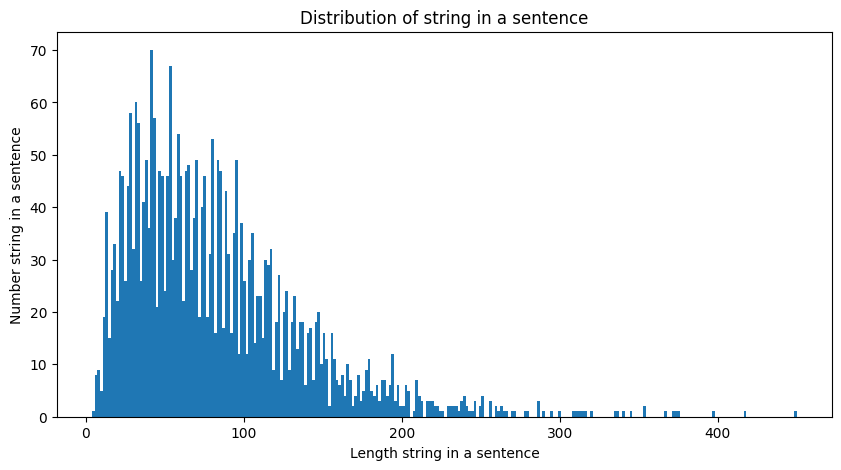

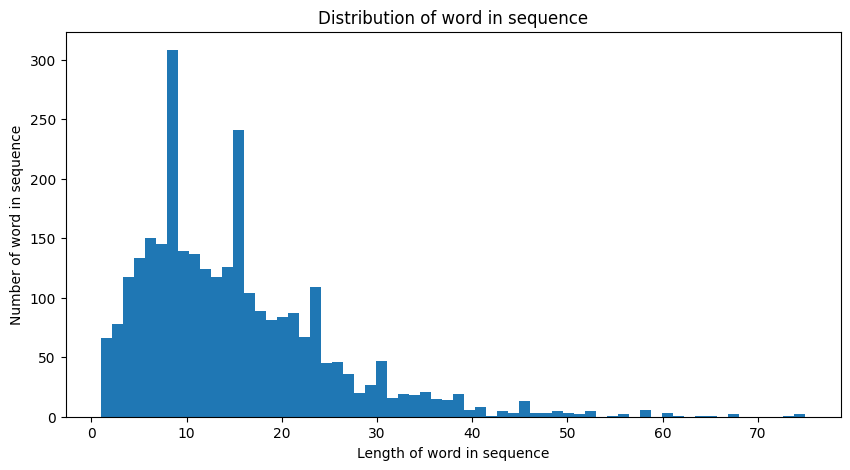

In [91]:
def type_of_datasets(x):
    return x[0].keys()

def mean_of_sentence(x):
    return sum([len(s) for s in x])/len(x)

def distribution_of_sentence(x):
    list_len = [len(s) for s in x]
    unique_count = len(np.unique(list_len))
    plt.figure(figsize=(10,5))
    plt.title("Distribution of string in a sentence")
    plt.xlabel("Length string in a sentence")
    plt.ylabel("Number string in a sentence")
    plt.hist(list_len, bins= unique_count)

def mean_of_word_in_sequence(x):
    return sum([len(s.split()) for s in x])/len(x)

def distribution_of_word_in_sequence(x):
    list_len = [len(s.split()) for s in x]
    unique_count = len(np.unique(list_len))
    plt.figure(figsize=(10,5))
    plt.title("Distribution of word in sequence")
    plt.xlabel("Length of word in sequence")
    plt.ylabel("Number of word in sequence")
    plt.hist(list_len, bins= unique_count)

def distribution_standard(x):
    return np.std([len(s.split()) for s in x])
    

print(f"datasets keys: {type_of_datasets(train_dataset)}")
print(f"exampls of string sentence:\n 1) {train_dataset['text'][np.random.randint(0,len(train_dataset))]}\n 2) {train_dataset['text'][np.random.randint(0, len(train_dataset))]}\n 3) {train_dataset['text'][np.random.randint(0, len(train_dataset))]})]")
distribution_of_sentence(train_dataset['text'])
print(f"mean of sentence --> {mean_of_sentence(train_dataset['text'])}")
distribution_of_word_in_sequence(train_dataset['text'])
print(f"mean of word in sequence --> {mean_of_word_in_sequence(train_dataset['text'])}")
print(f"example of split sentence: {train_dataset['text'][np.random.randint(0, len(train_dataset))].split()}")
print(f"standard deviation of word in sequence --> {distribution_standard(train_dataset['text'])}")
print(f"example of tokens: \n 1) {train_dataset['tokens'][np.random.randint(0, len(train_dataset))]} \n 2) {train_dataset['tokens'][np.random.randint(0, len(train_dataset))]} \n 3) {train_dataset['tokens'][np.random.randint(0, len(train_dataset))]} \n 4) {train_dataset['tokens'][np.random.randint(0, len(train_dataset))]}")
print(f"heads of tokens: \n 1) {train_dataset['head'][np.random.randint(0, len(train_dataset))]} \n 2) {train_dataset['head'][np.random.randint(0, len(train_dataset))]} \n 3) {train_dataset['head'][np.random.randint(0, len(train_dataset))]} \n 4) {train_dataset['head'][np.random.randint(0, len(train_dataset))]}")


# BiLSTM Neural Network for Dependency Parsing

The code implements a Bidirectional Long Short-Term Memory (BiLSTM) neural network for dependency parsing. The neural network is trained to predict the heads of words in a sentence, which form the dependency tree structure.

## Class:
1. The `NNParameters` class stores the parameters and hyperparameters for the neural network model. It includes attributes such as batch size, embedding size, LSTM size, number of LSTM layers, MLP output size, number of output classes, dropout rate, learning rate, and number of epochs.

2. The `NNData` class represents a data instance used for training and evaluation. It contains attributes for the encoded tokens (`enc_tokens`), configurations (`confs`), moves (`moves`), and heads (`heads`) of a sentence.

## Function: 
1. The `extract_att` function takes a list of `NNData` objects and extracts a specific attribute from each object.
2. The `create_dictionary` function creates a word-index mapping based on a dataset. It counts the occurrences of each word in the dataset and includes words that appear at least a specified threshold number of times in the vocabulary. The function returns a dictionary mapping words to their corresponding indices.
3. The `process_sample` function processes a sample from the dataset. It takes a sample and an embedding dictionary as input. It adds the `<ROOT>` token to the beginning of the sentence and -1 to the beginning of the head. It encodes the sentence using the provided embedding dictionary. If `get_gold_path` is True, it also generates the gold path and gold moves for the sample.
4. The `process_batch` function processes a batch of samples by calling `process_sample` for each sample. It takes a batch of samples, an embedding dictionary, and an optional flag `get_gold_path` as input. The function returns a list of `NNData` objects containing the processed data for each sample in the batch.
5. The `train` function performs the training loop for the neural network. It takes the model, dataloader, criterion, and optimizer as input. It iterates over the batches in the dataloader, performs a forward pass through the model, calculates the loss using the specified criterion, performs backpropagation, and updates the model's parameters using the optimizer.
6. The `evaluate` function calculates the accuracy of the predicted heads compared to the gold heads. It takes the gold heads and predicted heads as input and computes the accuracy by comparing with **cross entropy**.
7. The `test` function evaluates the model's performance on the test dataset. It takes the model and dataloader as input. It iterates over the batches in the dataloader, makes predictions using the model, and collects the gold heads and predicted heads. Finally, it calls the `evaluate` function to calculate the accuracy based on the collected data.

The code provides the necessary components to train, evaluate, and test the BiLSTM neural network for dependency parsing. It includes data processing functions, training loop, and evaluation functions to facilitate the training and evaluation process.

In [10]:
class NNParameters():
  def __init__(self) -> None:
      self.BATCH_SIZE = BATCH_SIZE
      self.EMBEDDING_SIZE = 200
      self.FREEZE = True
      self.LSTM_SIZE = 200
      self.LSTM_LAYERS = 2
      self.MLP_OUT_SIZE = self.LSTM_LAYERS * self.LSTM_SIZE
      self.OUT_CLASSES = 4
      
      self.DROP_OUT = 0.2
      self.LR = 0.001
      self.EPOCHS = 1

nnp = NNParameters()

class NNData():
  def __init__(self, tokens, confs, moves, heads) -> None:
      self.enc_tokens = tokens
      self.confs = confs
      self.moves = moves
      self.heads = heads
      #self.dictionary = dictionary

def extract_att(data:List[NNData], attribute:str):
  return [getattr(d, attribute) for d in data]
      

def create_dictionary(dataset, threshold: int =3) -> dict[str, int]:
    """
    Extract from corpus vocabulary V of unique words that appear at least threshold times.
    input:
        dataset: list of sentences, each sentence is a list of words
        treashold: minimum number of times a word must appear in the corpus to be included in the vocabulary
        
    output:
        map: dictionary of word/index pairs. This is our embedding list
    """
    dic = {}  # dictionary of word counts
    for sample in dataset:
        for word in sample["tokens"]:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 1

    map = {}  # dictionary of word/index pairs. This is our embedding list
    map["<pad>"] = 0
    map["<ROOT>"] = 1
    map["<unk>"] = 2  # used for words that do not appear in our list

    next_indx = 3
    for word in dic.keys():
        if dic[word] >= threshold:
            map[word] = next_indx
            next_indx += 1

    return map


def process_sample(sample, emb_dictionary, get_gold_path=False):
    """
    Process a sample from the dataset
    1. Add ["<ROOT>"] to the beginning of the sentence and [-1] to the beginning of the head
    2. Encode the sentence and the gold path
    
    
    :param         tokens: tokens of a sentence
    :param emb_dictionary: dictionary of word/index pairs
    :param  get_gold_path: if True, we also return the gold path and gold moves
    :return: enc_sentence: encoded tokens of the sentence
                gold_path: gold path of the sentence
               gold_moves: gold moves of the sentence
                     gold: gold heads of the sentence
    """
    sentence = ["<ROOT>"] + sample["tokens"]
    head = [(-1)] + list(map(int, sample["head"]))  # [int(i) for i in tokens["head"]]

    # embedding ids of sentence words
    enc_sentence = [
        emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"]
        for word in sentence
    ]


    if get_gold_path:
        gold_moves, gold_path, _= generate_gold(sentence, head) # transform matrix from nx3 to 3xn
    else:
        gold_path, gold_moves = [], []

    return enc_sentence, gold_path, gold_moves, head


def process_batch(batch:List[List], emb_dictionary:dict[str,int], get_gold_path:bool=False) -> List[NNData]:
  pack:List[NNData]=[]

  for sample in batch:
    s, c, m, h= process_sample(sample, emb_dictionary, get_gold_path=get_gold_path)
    pack.append(NNData(s, c, m, h))

  return pack 

def train(model: nn.Module, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 1
  for batch in dataloader:
    print(f"TRAIN: batch {count}/{len(dataloader):.0f}")
    optimizer.zero_grad()
    
    out = model(batch)

    moves= extract_att(batch, "moves")
    labels = torch.tensor(sum(moves, [])).to(
        device
    )  # sum(moves, []) flatten the array
    
    loss = criterion(out, labels)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    count += 1

  return total_loss / count

def evaluate(gold:List[List[int]], preds:List[List[int]]):
    total = 0
    correct = 0

    for g, p in zip(gold, preds):
        for i in range(1, len(g)):
            total += 1
            if g[i] == p[i]:
                correct += 1

    return correct / total

def test(model, dataloader: torch.utils.data.dataloader):  # type:ignore
  model.eval()

  gold = []
  preds = []
  count=0

  for batch in dataloader:
    print(f"test: batch {count}/{len(dataloader):.0f}")

    with torch.no_grad():
        pred = model.infere(batch)
        gold += extract_att(batch, "heads")
        preds += pred

  return evaluate(gold, preds)

# BiLSTMNet Definition

The `BiLSTMNet` class is a neural network model for dependency parsing based on Bidirectional Long Short-Term Memory (BiLSTM).

## Class: 
- `get_mlp_input`: Constructs the input for the MLP layers. It takes a list of configurations and hidden states as input and returns the input tensor for the MLP layers.
- `mlp_pass`: Performs a forward pass through the MLP layers. It takes the input tensor `x` and returns the output tensor after passing through the MLP layers.
- `lstm_pass`: Performs a forward pass through the LSTM layer. It takes the input tensor `x` and returns the output hidden states.
- `forward`: Performs the forward pass of the BiLSTMNet model. It takes a batch of `NNData` objects as input and returns the output tensor after passing through the model.
- `infer`: Performs inference using the BiLSTMNet model. It takes a batch of data and returns the predicted dependency trees.

The code implements the BiLSTMNet model for dependency parsing. It includes the necessary functions to initialize the model, perform forward pass, and conduct inference.

In [11]:
class BiLSTMNet(nn.Module):
  def __init__(self,device, dictionary,  *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.device = device
    self.embeddings = nn.Embedding(
      len(dictionary),
      nnp.EMBEDDING_SIZE,
      padding_idx=dictionary["<pad>"]
    )

    self.lstm = nn.LSTM(
      nnp.EMBEDDING_SIZE,
      nnp.LSTM_SIZE,
      num_layers=nnp.LSTM_LAYERS,
      bidirectional=True,
      dropout=nnp.DROP_OUT,
    )
    
    self.w1 = nn.Linear(2 * nnp.LSTM_LAYERS * nnp.LSTM_SIZE, nnp.MLP_OUT_SIZE, bias=True)
    self.activation = nn.Tanh()
    self.w2 = nn.Linear(nnp.MLP_OUT_SIZE, nnp.OUT_CLASSES, bias=True)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(nnp.DROP_OUT)
  
  def get_mlp_input(self, configurations, h):
      mlp_input = []
      zero_tensor = torch.zeros(
          2 * nnp.LSTM_SIZE, requires_grad=False, device=self.device
      )
      for i in range(len(configurations)):
          for j in configurations[i]:  # for each configuration of a sentence
              mlp_input.append(
                  torch.cat(
                      [
                          zero_tensor if j[0] == -1 else h[j[0]][i],
                          zero_tensor if j[1] == -1 else h[j[1]][i],
                      ]
                  )
              )
      mlp_input = torch.stack(mlp_input).to(self.device)
      return mlp_input

  def mlp_pass(self, x):
      return self.softmax(
          self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))
      )

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, _ = self.lstm(x)
    h, _ = torch.nn.utils.rnn.pad_packed_sequence(h)
    return h
  
  def forward(self, batch:List[NNData]):
    tokens = extract_att(batch, "enc_tokens")
    x = [self.dropout(self.embeddings(torch.tensor(t).to(self.device))) for t in tokens]

    h = self.lstm_pass(x)
    
    configurations:List[List[Tuple[int,int]]] = extract_att(batch, "confs")
    mlp_input = self.get_mlp_input(configurations, h)
    out = self.mlp_pass(mlp_input)
    return out

  def infere(self, batch):
    start_time=time.time()
    tokens=extract_att(batch, "enc_tokens")
    parsers: List[ArcEager] = [ArcEager(t) for t in tokens]

    x = [self.embeddings(torch.tensor(t).to(self.device)) for t in tokens]
    h = self.lstm_pass(x)
    print("time lstm", time.time()-start_time)

    start_time=time.time()
    is_final = [False] 
    while not all(is_final):
      # get the current configuration and score next moves
      configurations = [[p.get_configuration_now()] for p in parsers]
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp_pass(mlp_input)
      # take the next parsing step
      list_moves= parse_moves(parsers, mlp_out)
      for i,m in enumerate(list_moves):
          parsers[i].do_move(m)
      is_final=[t.is_tree_final() for t in parsers]
          
    print("time parse", time.time()-start_time)

    # return the predicted dependency tree
    return [parser.list_arcs for parser in parsers]

# Dataloader
The provided code sets up data loaders for training, validation, and testing datasets using the `torch.utils.data.DataLoader` class.

1. `create_dictionary`: Creates a word-index mapping dictionary based on the training dataset.
2. `torch.utils.data.DataLoader`: Creates a data loader for the training, test, validation dataset with batch size, shuffling, and data processing using `process_batch` function with gold path and moves.

These data loaders facilitate the training, validation, and testing processes by providing batches of data, shuffling the data, and applying the necessary data processing steps.

In [12]:
dictionary= create_dictionary(train_dataset)

train_dataloader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=nnp.BATCH_SIZE, 
  shuffle=True,
  collate_fn=lambda x: process_batch(x, dictionary, get_gold_path=True)
)

validation_dataloader= torch.utils.data.DataLoader(
  validation_dataset,
  batch_size=nnp.BATCH_SIZE,
  shuffle=True,
  collate_fn=lambda x: process_batch(x, dictionary, get_gold_path=True)
)

test_dataloader= torch.utils.data.DataLoader(
  test_dataset,
  batch_size=nnp.BATCH_SIZE,
  shuffle=True,
  collate_fn=lambda x: process_batch(x, dictionary, get_gold_path=False)
)

# Traing and evaluation
The code trains the BiLSTMNet model using the training dataset and evaluates the model's performance on the validation dataset. It uses the `train` and `evaluate` functions to perform the training and evaluation processes.
`criterion` used to calculate the loss is **Cross Entropy**.
`optimizer` used to update the model's parameters is **Adam**.


In [13]:
model = BiLSTMNet(device, dictionary).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=nnp.LR)

for epoch in range(nnp.EPOCHS):
  print("Starting Epoch", epoch)
  # torch.load(f"bilstm_e{epoch+1}.pt")
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, validation_dataloader)

  log = f"Epoch: {epoch:3d} | avg_train_loss: {avg_train_loss:5.3f} | dev_uas: {val_uas:5.3f} |"
  print(log)

  # save the model on pytorch format
  torch.save(model.state_dict(), f"bilstm_e{epoch+1}.pt")

test_uas = test(model, test_dataloader)
log = "test_uas: {:5.3f}".format(test_uas)
print(log)
train(model, train_dataloader, criterion, optimizer)

Starting Epoch 0
TRAIN: batch 1/12


# BERT Parameter
## Class:
The `NNParameters` class defines the parameters and hyperparameters for a neural network model. It has the following attributes:

- `BATCH_SIZE`: The batch size used during training.
- `BERT_SIZE`: The size of the BERT embeddings.
- `EMBEDDING_SIZE`: The size of the input embeddings, which is set to the same value as `BERT_SIZE`.
- `DIM_CONFIG`: The dimensionality of the configuration.
- `MLP1_IN_SIZE`: The input size of the first MLP layer, calculated as the product of `DIM_CONFIG` and `EMBEDDING_SIZE`.
- `MLP2_IN_SIZE`: The input size of the second MLP layer, set to 300.
- `OUT_CLASSES`: The number of output classes.
- `FREEZE`: A flag indicating whether to freeze the model's parameters during training.
- `DROP_OUT`: The dropout rate used in the model.
- `LR`: The learning rate used for optimization.
- `EPOCHS`: The number of training epochs.

The `NNData` class represents a data instance used for training and evaluation. It has the following attributes:

- `sentence`: The input sentence.
- `confs`: The configurations of the sentence.
- `moves`: The moves made during parsing.
- `heads`: The predicted heads of the words in the sentence.
- `subw2word_idx`: The mapping of subwords to word indices.

## Function:

The `extract_att` function takes a list of `NNData` objects and an attribute name as input. It extracts the specified attribute from each `NNData` object in the list and returns a list containing the extracted attributes.

The code provides the necessary classes and functions to define the neural network model parameters, represent data instances, and extract attributes from a list of data objects.

In [ ]:
class NNParameters():
  def __init__(self) -> None:
      self.BATCH_SIZE = BATCH_SIZE 
      self.BERT_SIZE = 768
      self.EMBEDDING_SIZE = self.BERT_SIZE
      self.DIM_CONFIG = 2
      self.MLP1_IN_SIZE = self.DIM_CONFIG * self.EMBEDDING_SIZE
      self.MLP2_IN_SIZE = 300
      self.OUT_CLASSES = 4
      self.FREEZE = True
      self.DROP_OUT = 0.2
      self.LR = 0.01
      self.EPOCHS = 1

nnp = NNParameters()

class NNData():
  def __init__(self,sentence, confs, moves, heads, subw2word_idx) -> None:
      self.sentence = sentence
      self.confs = confs
      self.moves = moves
      self.heads = heads
      self.subw2word_idx = subw2word_idx

def extract_att(data:List[NNData], attribute:str):
  return [getattr(d, attribute) for d in data]

The provided code performs data preprocessing and batch processing for dependency parsing using the BERT tokenizer. Here's a breakdown of the code:

- `AutoTokenizer.from_pretrained('bert-base-uncased')`: This line initializes a BERT tokenizer from the `'bert-base-uncased'` pretrained model.
- `calcualate_subw2word_idx`: This function calculates the mapping of subword indices to word indices.
- `process_sample`: This function processes a sample from the dataset. It adds "<ROOT>" to the beginning of the sentence and -1 to the beginning of the head. It encodes the sentence using the tokenizer and returns the encoded sentence, gold path, gold moves, and subword-to-word index mappings. If `get_gold_path` is True, it also calculates the gold path and gold moves based on the sentence and head.
- `process_batch`: This function processes a batch of data samples..

The code provides the necessary functions to tokenize sentences, calculate subword-to-word indices, process individual samples, and process batches of data for dependency parsing using BERT tokenizer.

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer.add_tokens(["<ROOT>", "<EMPTY>"], special_tokens=True)

def calcualate_subw2word_idx(subw_idx):
  tokens=tokenizer.convert_ids_to_tokens(subw_idx)
  i=0
  o=[]
  while i<len(tokens):
    t=[]
    t.append(i)
    i+=1
    while i<len(tokens) and tokens[i].startswith("##"):
      t.append(i)
      i+=1
    o.append(t)
  return o

def process_sample(sample, sentence, iid, get_gold_path=False):
    """
    Process a sample from the dataset
    1. Add ["<ROOT>"] to the beginning of the sentence and [-1] to the beginning of the head
    2. Encode the sentence and the gold path
    
    
    :param         tokens: tokens of a sentence
    :param emb_dictionary: dictionary of word/index pairs
    :param  get_gold_path: if True, we also return the gold path and gold moves
    :return: enc_sentence: encoded tokens of the sentence
                gold_path: gold path of the sentence
               gold_moves: gold moves of the sentence
                     gold: gold heads of the sentence
    """

    head = [(-1)] + list(map(int, sample["head"]))  # [int(i) for i in tokens["head"]]

    # embedding ids of sentence words
    subw2word_idx=calcualate_subw2word_idx(iid)

    if get_gold_path:
        gold_moves, gold_path, _= generate_gold(sentence, head) # transform matrix from nx3 to 3xn
    else:
        gold_path, gold_moves = [], []

    return head, gold_path, gold_moves, subw2word_idx


def process_batch(batch:List[List], tokenizer, get_gold_path:bool=False) :
  pack:List[NNData]=[]
  sentences=[["<ROOT>"]+ bd["tokens"] for bd in batch]

  ## Tokenizer -> get token_ids, attention_mask and token_type_ids
  output_tokenizer= tokenizer(
      ["<ROOT> "+ bd["text"] for bd in batch],
      padding=True, 
      return_tensors="pt",
      add_special_tokens=False 
  )

  token_ids:List[List[int]]=output_tokenizer["input_ids"]
  attention_mask=output_tokenizer["attention_mask"]
  token_types_ids=output_tokenizer["token_type_ids"] 
  ###########
  ## What is left? heads, gold_path, gold_moves, subw2word_idx
  ## What i need? sample -> heads, original sentence -> golds, input_ids -> subw2word_idx
  for sample, sentence, iid in zip(batch,sentences,token_ids):
    head, configuration, moves, s2w= process_sample(sample, sentence,iid, get_gold_path=get_gold_path)
    pack.append(NNData(sentence, configuration, moves, head, s2w))

  return output_tokenizer, pack

# BERTNet

The `BERTNet` class is a neural network model for dependency parsing based on Bidirectional Encoder Representations from Transformers (BERT).

## Class: BERTNet

- `get_embedding`: Retrieves the embeddings for a given index from the hidden states `h` of the BERT model.
- `get_mlp_input`: Constructs the input tensor for the MLP layers. It takes a list of configurations, subword-to-word index mappings, and hidden states `h`. It concatenates the embeddings for each configuration and returns the resulting tensor.
- `mlp_pass`: Performs a forward pass through the MLP layers. It takes the input tensor `x` and returns the output tensor after passing through the MLP layers.
- `forward`: Performs the forward pass of the BERTNet model.
- `infer`: Performs inference using the BERTNet model. It takes a batch of data and performs dependency parsing. It applies BERT embeddings to the input, retrieves the tokens and subword-to-word index mappings from `NNData`, and iteratively performs parsing steps until a final dependency tree is obtained. 

The code implements the BERTNet model for dependency parsing. It includes the necessary functions to initialize the model, perform forward pass, and conduct inference.

In [ ]:
class BERTNet(nn.Module):
  def __init__(self,device, tokenizer,  *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.device = device
    self.embeddings = nn.Embedding(
      len(tokenizer),
      nnp.EMBEDDING_SIZE,
      padding_idx=0
    )

    
    self.bert = AutoModel.from_pretrained('bert-base-uncased')
    self.bert.resize_token_embeddings(len(tokenizer))
    
    # Freeze bert layers
    if nnp.FREEZE:
      for param in self.bert.parameters():
        param.requires_grad = False
    
    self.w1 = nn.Linear(nnp.MLP1_IN_SIZE, nnp.MLP2_IN_SIZE, bias=True)
    self.activation = nn.Tanh()
    self.w2 = nn.Linear(nnp.MLP2_IN_SIZE, nnp.OUT_CLASSES, bias=True)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(nnp.DROP_OUT)
  
  def get_embedding(self, h, idx):
      return torch.mean(h[idx], dim=0)

  def get_mlp_input(self, configurations, subw2idx, h):
      mlp_input = []
      zero_tensor = torch.zeros(
          nnp.BERT_SIZE, requires_grad=False, device=self.device
      )
      for i in range(len(configurations)):
          for j in configurations[i]:  # for each configuration of a sentence
              mlp_input.append(
                  torch.cat(
                      [
                          zero_tensor if j[0] == -1 else self.get_embedding(h[i], subw2idx[i][j[0]]),
                          zero_tensor if j[1] == -1 else self.get_embedding(h[i], subw2idx[i][j[1]]),
                      ]
                  )
              )
      mlp_input = torch.stack(mlp_input).to(self.device)
      return mlp_input

  def mlp_pass(self, x):
      return self.softmax(
          self.w2(self.dropout(self.activation(self.w1(self.dropout(x)))))
      )

  
  def forward(self, batch:Tuple[BatchEncoding,List[NNData]]):
    output_tokenizer = batch[0].to(self.device)
    input_ids= output_tokenizer["input_ids"]
    attention_mask= output_tokenizer["attention_mask"] 
    input_ids=input_ids.to(self.device)
    attention_mask=attention_mask.to(self.device)

    h = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.to(self.device)
    
    nndata=batch[1]
    configurations = extract_att(nndata, "confs")
    subw2idx = extract_att(nndata, "subw2word_idx")
    mlp_input = self.get_mlp_input(configurations,subw2idx, h)

    out = self.mlp_pass(mlp_input)
    return out

  def infere(self, batch):
    output_tokenizer, nndata= batch
    output_tokenizer=output_tokenizer.to(self.device)
    input_ids= output_tokenizer["input_ids"]
    attention_mask= output_tokenizer["attention_mask"] 
    input_ids=input_ids.to(self.device)
    attention_mask=attention_mask.to(self.device)

    h = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.to(self.device)

    tokens = extract_att(nndata, "sentence")
    parsers: List[ArcEager] = [ArcEager(t) for t in tokens]


    subw2idx = extract_att(nndata, "subw2word_idx")
    is_final = [False] 
    while not all(is_final):
      # get the current configuration and score next moves
      configurations = [[p.get_configuration_now()] for p in parsers]
      mlp_input = self.get_mlp_input(configurations, subw2idx, h)
      mlp_out = self.mlp_pass(mlp_input)
      # take the next parsing step
      list_moves= parse_moves(parsers, mlp_out)
      for i,m in enumerate(list_moves):
          parsers[i].do_move(m)
      is_final=[t.is_tree_final() for t in parsers]
          

    # return the predicted dependency tree
    return [parser.list_arcs for parser in parsers]

# Dataloader
Load the data again as done before

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=nnp.BATCH_SIZE, 
  shuffle=True,
  collate_fn=lambda x: process_batch(x, tokenizer, get_gold_path=True)
)
validation_dataloader= torch.utils.data.DataLoader(
  validation_dataset,
  batch_size=nnp.BATCH_SIZE,
  shuffle=True,
  collate_fn=lambda x: process_batch(x,tokenizer, get_gold_path=True)
)
test_dataloader= torch.utils.data.DataLoader(
  test_dataset,
  batch_size=nnp.BATCH_SIZE,
  shuffle=True,
  collate_fn=lambda x: process_batch(x, tokenizer, get_gold_path=False)
)

## Training and Evaluation

The code trains the `BERTNet` model using the training dataset and evaluates its performance on the validation dataset. It utilizes the cross-entropy loss criterion for training and the Adam optimizer for parameter updates. The model's performance is evaluated using a validation score, typically measured by metrics like UAS (Unlabeled Attachment Score). After training, the model is evaluated on the test dataset, and the test performance is reported.

In [ ]:
model = BERTNet(device, tokenizer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=nnp.LR)

for epoch in range(nnp.EPOCHS):
  print("Starting Epoch", epoch)
  # torch.load(f"bilstm_e{epoch+1}.pt")
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  if epoch % 5 == 0:
    val_uas = test(model, validation_dataloader)
  else:
    val_uas = -1
    

  log = f"Epoch: {epoch:3d} | avg_train_loss: {avg_train_loss:5.3f} | dev_uas: {val_uas:5.3f} |"
  print(log)

  # save the model on pytorch format
  torch.save(model.state_dict(), f"bilstm_e{epoch+1}.pt")

test_uas = test(model, test_dataloader)
log = "test_uas: {:5.3f}".format(test_uas)
print(log)
train(model, train_dataloader, criterion, optimizer)

print("--- %s seconds ---" % (time.time() - start_time))